# Similarity Score

In [2]:
#read sample dataset
with open("../data/OpenSubtitles/OpenSubtitles_sample.th", "r", encoding='utf-8') as f:
    th_lines = f.readlines()
    th_lines = [i[:-1] for i in th_lines]
with open("../data/OpenSubtitles/OpenSubtitles_sample.zh_cn", "r", encoding='utf-8') as f:
    zh_lines = f.readlines()
    zh_lines = [i[:-1] for i in zh_lines]

In [3]:
len(th_lines)

100

In [4]:
th_lines[:10]

['คุณจำตอนพิธีล้างบาปของคุณได้ เป็นไปได้ยังไง?',
 'เป็นไปไม่ได้รึไง? แต่มันจริงนะ',
 'คุณได้ยินผู้ใหญ่เขาคุยกันรึเปล่า?',
 'ฉันรู้สึกได้ถึงแสงอาทิตย์ลอดผ่านกระจกเข้ามา',
 'ฉันยังจำเสียงหัวใจเต้นของพ่อได้',
 'ไม่ใช่ฉันที่จำได้ แต่เป็นความทรงจำของฉันต่างหาก',
 'แต่คุณไม่ใช่ คาธอลิกแล้วนี่?',
 'เขาปล่อยให้คนอื่นผ่านไป',
 'ทำไมอยู่ดีๆถึงพูดเรื่องพิธีล้างบาปขึ้นมาล่ะ?',
 'ฉันนึกถึงมันบ่อยๆ บางทีฉันก็จำได้']

In [5]:
len(zh_lines)

100

In [6]:
zh_lines[:10]

['记得自己的洗礼仪式 这可能吗?',
 '不可能?',
 '可那是事实啊 是听大人们说的吧?',
 '我能感受到透过玻璃的阳光',
 '我还记得爸爸的心跳声呢',
 '真的不是听来的 是记忆里的',
 '你也不是信天主教的吧',
 '改新教也有洗礼这种仪式',
 '为什么忽然提起洗礼仪式?',
 '最近想起来的 偶尔会想起']

## multilingual universal sentence encoder

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

In [12]:
def get_similar_score(lang1: str, lang2: str, batch_size: int, embed):

    scores = []

    if len(lang1) % batch_size != 0:
        num_of_batch = int(len(lang1)/batch_size)+1
    else:
        num_of_batch = int(len(lang1)/batch_size)

    for i in range(num_of_batch):
        start = i*batch_size
        end = start+batch_size
        if i <= num_of_batch:

            lang1_temp = lang1[start:end]
            lang2_temp = lang2[start:end]

            lang1_embedding = embed(lang1_temp)
            lang2_embedding = embed(lang2_temp)
            distance_matrix = tf.matmul(
                lang1_embedding, lang2_embedding, transpose_b=True).numpy()

            for j in range(len(distance_matrix)):
                scores.append(distance_matrix[j][j])

    return scores

In [13]:
zhs = [
    '我吃食物',
    '她喜歡看電視',
    '她為什麼喜歡吃電視',
    '我吃食物',
    '她喜歡看電視',
    '她為什麼喜歡吃電視'
]
ths = [
    'ฉันกินอาหาร',
    'เธอชอบดูทีวี',
    'ทำไมเธอถึงชอบกินทีวี',
    'ฉันไม่ชอบกินอาหาร',
    'เธอเกลียดทีวี',
    'ทำไมทีวีกินเธอเข้าไป',
]


In [14]:
emb = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3', tags=None, options=None)

In [15]:
get_similar_score(zhs, ths, 16, emb)

[0.93829453, 0.8440465, 0.82446057, 0.62734914, 0.6408375, 0.7583015]

In [16]:
sims = get_similar_score(zh_lines, th_lines, 16, emb)

In [23]:
import pandas as pd
#find a good threshold with full dataset
sim_df = pd.DataFrame({'zh':zh_lines, 'th': th_lines, 'similarity_score':sims}).sort_values('similarity_score')
sim_df

,zh,th,similarity_score
7,改新教也有洗礼这种仪式,เขาปล่อยให้คนอื่นผ่านไป,0.040723
22,真是小气,คุณคิดเอาไว้ก่อนอยู่แล้วจริงๆ,0.120773
84,例如,การจ่ายค่าชดเชย,0.124281
17,还是 一人分一张,หรือว่าเราควรไปทางใครทางมัน พาคนอื่นมาแทนดี?,0.125284
93,和同龄人上课后做XX* 再如 把错拿的东西归还回来,และก็มีเวลาที่คุณต้องคืนของที่ยืมมา,0.176312
...,...,...,...
10,第1集,ตอนที่ 1,0.836212
68,真的?,จริงเหรอ?,0.871570
90,这个为什么会在厨房里,ทำไมนี่ถึงอยู่ในครัวน่ะ,0.872231
76,什么?,อะไรนะ?,0.953017


In [24]:
sim_df.describe()

,similarity_score
count,100.000000
mean,0.521489
std,0.187168
min,0.040723
25%,0.409993
50%,0.523687
75%,0.623350
max,0.975215


<AxesSubplot:ylabel='Frequency'>

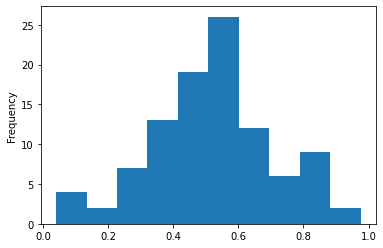

In [28]:
sim_df['similarity_score'].plot(kind='hist', bins=10)